In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

# def getfile(location_pair,**kwargs): #tries to get local version and then defaults to google drive version
#     (loc,gdrive)=location_pair
#     try:
#         out=pd.read_pickle(loc,**kwargs)
#     except FileNotFoundError:
#         print("local file not found; accessing Google Drive")
#         loc = 'https://drive.google.com/uc?export=download&id='+gdrive.split('/')[-2]
#         out=pd.read_pickle(loc,**kwargs)
#     return out

# # Load our dataset
# url = "https://drive.google.com/file/d/1xG-ruT7PqEXD10Hksqn9EJfWvoHTuodB/view?usp=sharing"
# energy_price_data=getfile(("all_data.pkl",url))

loc = '../Data/all_data.pkl'
energy_price_data = pd.read_pickle(loc).drop_duplicates().reset_index(drop=True)
energy_price_data = energy_price_data[energy_price_data['Date'] >= '2020-01-01']
energy_price_data

,Date,Forecasted Load (MISO),Day Ahead Energy Price (IL),Energy Price (IL),Sin_Month,Cos_Month,Sin_Day,Cos_Day,Sin_Hour,Cos_Hour,Energy Price (MICHIGAN.HUB),Energy Price (MINN.HUB),Energy Price (INDIANA.HUB),Energy Price (TEXAS.HUB),Energy Price (LOUISIANA.HUB),Energy Price (ARKANSAS.HUB),Energy Price (MS.HUB),Temperature
11169,2020-01-01 01:00:00,0.248875,0.084729,0.041956,0.75,0.933013,1.0,0.25,0.635214,0.981372,0.020650,0.041148,0.011824,0.028077,0.055516,0.028281,0.035388,0.412651
11170,2020-01-01 02:00:00,0.227755,0.082722,0.042409,0.75,0.933013,1.0,0.25,0.760399,0.926869,0.020936,0.040769,0.012101,0.028160,0.055603,0.028365,0.035473,0.403614
11171,2020-01-01 03:00:00,0.216184,0.086044,0.041091,0.75,0.933013,1.0,0.25,0.866272,0.840534,0.019897,0.040340,0.011134,0.027920,0.055364,0.028124,0.035230,0.394578
11172,2020-01-01 04:00:00,0.209648,0.083391,0.040044,0.75,0.933013,1.0,0.25,0.944980,0.728769,0.019186,0.039896,0.010515,0.027834,0.055250,0.028012,0.035108,0.387048
11173,2020-01-01 05:00:00,0.209844,0.082561,0.041229,0.75,0.933013,1.0,0.25,0.990686,0.599865,0.019983,0.040302,0.011233,0.028107,0.055538,0.028306,0.035407,0.382530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32637,2023-09-30 18:00:00,0.493497,0.148466,0.047180,0.00,0.500000,0.0,0.75,0.009314,0.599865,0.025952,0.053008,0.017139,0.032007,0.059056,0.031786,0.038839,0.837349
32638,2023-09-30 19:00:00,0.471059,0.135363,0.046723,0.00,0.500000,0.0,0.75,0.055020,0.728769,0.025401,0.052167,0.016586,0.031409,0.058586,0.031213,0.038407,0.813253
32639,2023-09-30 20:00:00,0.434116,0.121707,0.046252,0.00,0.500000,0.0,0.75,0.133728,0.840534,0.024072,0.046577,0.015297,0.030307,0.057572,0.030102,0.037360,0.793675
32640,2023-09-30 21:00:00,0.398046,0.109319,0.047428,0.00,0.500000,0.0,0.75,0.239601,0.926869,0.023574,0.042477,0.014818,0.029737,0.057029,0.029575,0.036797,0.778614


In this notebook, we will predict the actual energy price at Illinois hub using the dataset from Milestone 1.

We will use the following column in the dataset as feature:
1. `Sin_Month`, `Cos_Month`. Month in cyclical data format.
2. `Sin_Day`, `Cos_Day`. Day of the week in cyclical data format.
3. `Sin_Hour`, `Cos_Hour`. Hour of the day in cyclical data format.
4. `Temperature`. Air temperature at Illinois.
5. `Forecasted Load (MISO)`. Forecasted Load from MISO.
6. `Day Ahead Energy Price (IL)`. Day Ahead Energy Price at Illinois.
7. `Energy Price (MICHIGAN.HUB)`. Energy Price at Michigan hub.
8. `Energy Price (INDIANA.HUB)`. Energy Price at Indiana hub.
9. `Energy Price (LOUISIANA.HUB)`. Energy Price at Louisiana hub.
10. `Energy Price (ARKANSAS.HUB)`. Energy Price at Arkansas hub.

We will use the following column in the dataset as label:
1. `Energy Price (IL)`. Energy price at Illinois hub.

We split our dataset into training, validation, and test sets as follows:

*   Training set: data from 2020-01-01 to 2023-01-01.
*   Validation set: data from 2023-01-01 to 2023-05-01
*   Test set: data from 2023-06-01 to 2024-01-01

In [3]:
il_hub_data = energy_price_data[[
    'Date',
    'Sin_Month', 'Cos_Month', 'Sin_Day', 'Cos_Day','Sin_Hour', 'Cos_Hour',
    'Temperature',
    'Forecasted Load (MISO)',
    'Day Ahead Energy Price (IL)',
    'Energy Price (MICHIGAN.HUB)',
    'Energy Price (INDIANA.HUB)',
    'Energy Price (LOUISIANA.HUB)',
    'Energy Price (ARKANSAS.HUB)',
    'Energy Price (IL)'
    ]].drop_duplicates().reset_index(drop=True)

train_data = il_hub_data[('2020-01-01' <= il_hub_data['Date']) & (il_hub_data['Date'] < '2023-01-01')].drop(columns=['Date']).to_numpy()
val_data   = il_hub_data[('2023-01-01' <= il_hub_data['Date']) & (il_hub_data['Date'] < '2023-05-01')].drop(columns=['Date']).to_numpy()
test_data  = il_hub_data[('2023-06-01' <= il_hub_data['Date']) & (il_hub_data['Date'] < '2024-01-01')].drop(columns=['Date']).to_numpy()

X_train = train_data[:,:-1]
y_train = train_data[:,-1]
X_val = val_data[:,:-1]
y_val = val_data[:,-1]
X_test = test_data[:,:-1]
y_test = test_data[:,-1]

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(2)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(2)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(2)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)
print(f"X_train_tensor: {X_train_tensor.shape}, y_train_tensor: {y_train_tensor.shape}")
print(f"X_val_tensor: {X_val_tensor.shape}, y_val_tensor: {y_val_tensor.shape}")
print(f"X_test_tensor: {X_test_tensor.shape}, y_test_tensor: {y_test_tensor.shape}")

X_train_tensor: torch.Size([15712, 13, 1]), y_train_tensor: torch.Size([15712, 1])
X_val_tensor: torch.Size([2302, 13, 1]), y_val_tensor: torch.Size([2302, 1])
X_test_tensor: torch.Size([2774, 13, 1]), y_test_tensor: torch.Size([2774, 1])


**Build a deep learning model for the dataset**

Recall that we have 13 features, and some of them are highly correlated with each other. For example, the energy prices at all four hubs are highly correlated with the air tempurature in Illinois, as people typically consume more energy during cold weather. To capture these correlations in our deep learning model, we chose to use an RNN.

In the context of RNN, each data-label pair is treated as a time sequence $x[0],\ldots,x[13]$ where $x[t]$ dependeds on $x[s]$ for all $s < t$. In particular, we interpret the 13 features in the training data as the time sequence $x[0],\ldots,x[12]$, and the label is interpreted as $x[13]$. Our goal is to train a RNN model to predict $x[13]$ based on $x[0],\ldots,x[12]$.

Our RNN model takes a time sequence of shape $(N,13,1)$ as input, and outputs a vecotr of shape $(N,1)$, where $N$ represents the batch size.

In [4]:
# Define RNN model
input_size = X_train_tensor.shape[2]
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size=1):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:,-1,:])
        return out

We will first train our RNN model using the standard training approach. We choose `torch.nn.MSELoss` as the loss function and `torch.optim.Adam` as the optimizer.

Epoch [100/500], Loss: 2.73e-04
Epoch [200/500], Loss: 8.97e-05
Epoch [300/500], Loss: 7.40e-05
Epoch [400/500], Loss: 8.04e-05
Epoch [500/500], Loss: 6.48e-05
Validation loss: 1.66e-05


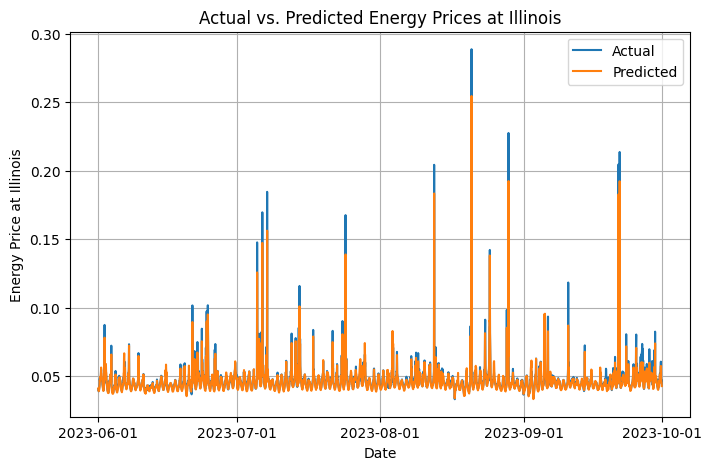

In [5]:
# hyperparameter
num_layers = 1          # The number of RNN layers
hidden_size = 64        # The number of features in the hidden state of each RNN layers

# Training loop
model = RNN(input_size, hidden_size, num_layers)
creterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 500
for epoch in range(num_epochs):
    outputs = model(X_train_tensor)
    loss = creterion(outputs, y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch+1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():4.2e}")

# Plot prediction
def plot_prediction(predictions):
    y_date = il_hub_data[['Date']]
    y_date = y_date[y_date['Date'] >= '2023-06-01']

    plt.figure(figsize=(8, 5))
    ax = plt.axes()
    plt.plot(y_date['Date'], y_test, label='Actual')
    plt.plot(y_date, predictions, label='Predicted')
    plt.xlabel('Date')
    plt.ylabel('Energy Price at Illinois')
    plt.title('Actual vs. Predicted Energy Prices at Illinois')
    ax.set_xticks(['2023-06-01','2023-07-01','2023-08-01','2023-09-01','2023-10-01'])
    plt.legend()
    plt.grid(True)
    plt.show()
print(f"Validation loss: {nn.MSELoss()(model(X_val_tensor), y_val_tensor).item():4.2e}")
predictions = model(X_test_tensor).detach().numpy()
plot_prediction(predictions)

**Investigate effects of mini-batch learning**

We now investigate effects of mini-batch learning using the minibatch size of $128$. We observe that mini-batch training significantly reduces the training time and generally results in a better-performing model.

Epoch [10/100], Loss: 7.38e-05
Epoch [20/100], Loss: 6.67e-05
Epoch [30/100], Loss: 6.72e-05
Epoch [40/100], Loss: 5.86e-05
Epoch [50/100], Loss: 5.84e-05
Epoch [60/100], Loss: 6.12e-05
Epoch [70/100], Loss: 6.26e-05
Epoch [80/100], Loss: 5.35e-05
Epoch [90/100], Loss: 5.86e-05
Epoch [100/100], Loss: 5.26e-05
Validation loss: 1.68e-05


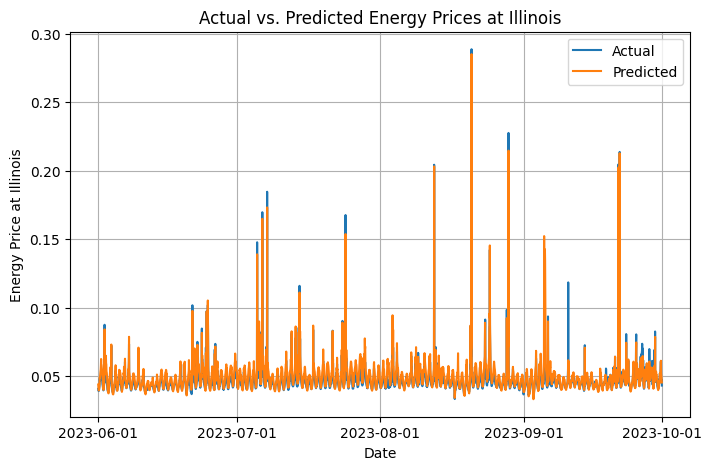

In [6]:
# Define batch size
batch_size = 128

# Class for loading custom dataset
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
train_loader = DataLoader(CustomDataset(X_train_tensor,y_train_tensor), batch_size, shuffle=True)

model = RNN(input_size, hidden_size, num_layers)
creterion = nn.MSELoss(reduction = 'sum')
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100
for epoch in range(num_epochs):
    loss_val = 0
    for X_batch, y_batch in train_loader:
        y_pred = model(X_batch)
        loss = creterion(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_val += loss.item()
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss_val/X_train_tensor.shape[0]:4.2e}")
print(f"Validation loss: {nn.MSELoss()(model(X_val_tensor), y_val_tensor).item():4.2e}")
predictions = model(X_test_tensor).detach().numpy()
plot_prediction(predictions)

**Investigate effects of different optimizers**

Previoulsely, we train our model using `torch.optim.Adam` and achieve reasonably good performance in terms of validation loss. To investigate the effect of different optimizers, we train our model using the follow optimizers:


1. `torch.optim.RMSprop`. Root mean square propagation method which has been used to train large-scaled RNNs in several works. For example https://arxiv.org/pdf/1308.0850v5.
2. `torch.optim.SGD`. Stochastic gradient descent with momentum, which has been reported to be effective for shallow RNNs.

We observe that all three optimizers, `Adam`, `RMSprop` and `SDP`, achieve comparable validation loss.

Training with RMSprop optimizer...
Epoch [10/100], Loss: 1.98e-04
Epoch [20/100], Loss: 1.81e-04
Epoch [30/100], Loss: 1.48e-04
Epoch [40/100], Loss: 1.33e-04
Epoch [50/100], Loss: 1.30e-04
Epoch [60/100], Loss: 9.12e-05
Epoch [70/100], Loss: 8.18e-05
Epoch [80/100], Loss: 7.90e-05
Epoch [90/100], Loss: 7.17e-05
Epoch [100/100], Loss: 6.80e-05
Validation loss: 2.17e-05


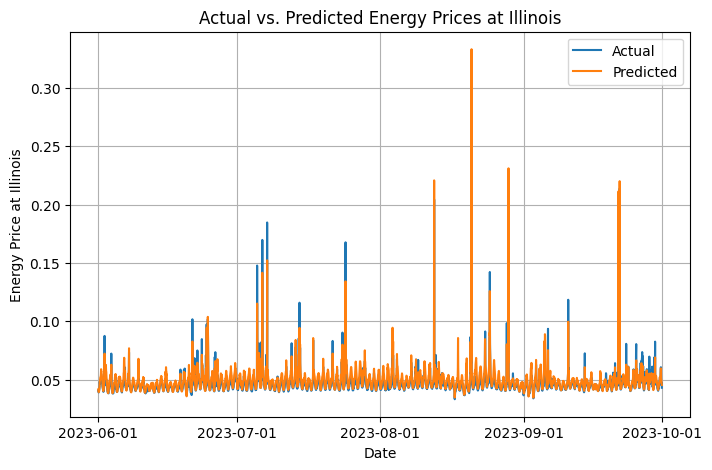

Training with SGD optimizer...
Epoch [10/100], Loss: 1.39e-04
Epoch [20/100], Loss: 9.42e-05
Epoch [30/100], Loss: 7.82e-05
Epoch [40/100], Loss: 6.94e-05
Epoch [50/100], Loss: 7.03e-05
Epoch [60/100], Loss: 6.46e-05
Epoch [70/100], Loss: 6.36e-05
Epoch [80/100], Loss: 6.24e-05
Epoch [90/100], Loss: 5.92e-05
Epoch [100/100], Loss: 5.98e-05
Validation loss: 3.95e-05


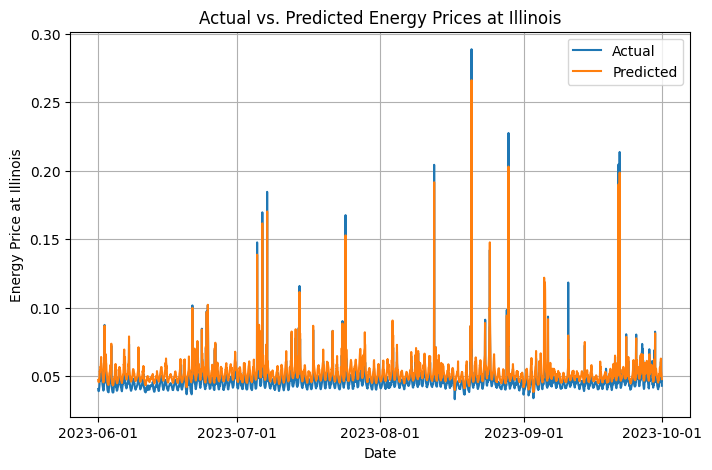

In [7]:
# Train model using RMSprop
print(f"Training with RMSprop optimizer...")
model = RNN(input_size, hidden_size, num_layers)
creterion = nn.MSELoss(reduction = 'sum')
optimizer = optim.RMSprop(model.parameters(), lr=0.001)
num_epochs = 100
for epoch in range(num_epochs):
    loss_val = 0
    for X_batch, y_batch in train_loader:
        y_pred = model(X_batch)
        loss = creterion(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_val += loss.item()
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss_val/X_train_tensor.shape[0]:4.2e}")
print(f"Validation loss: {nn.MSELoss()(model(X_val_tensor), y_val_tensor).item():4.2e}")
predictions = model(X_test_tensor).detach().numpy()
plot_prediction(predictions)

# Train model using SGD
print(f"Training with SGD optimizer...")
model = RNN(input_size, hidden_size, num_layers)
creterion = nn.MSELoss(reduction = 'sum')
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
num_epochs = 100
for epoch in range(num_epochs):
    loss_val = 0
    for X_batch, y_batch in train_loader:
        y_pred = model(X_batch)
        loss = creterion(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_val += loss.item()
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss_val/X_train_tensor.shape[0]:4.2e}")
print(f"Validation loss: {nn.MSELoss()(model(X_val_tensor), y_val_tensor).item():4.2e}")
predictions = model(X_test_tensor).detach().numpy()
plot_prediction(predictions)


**Tune hyperparameters (training testing and validation)**

Recall our RNN model has two typerparameters:
1.   `num_layers`. Number of recurrent layers.
2.   `hidden_size`. The number of features in each recurrent layer.

To find the best hyperparameters, we perform grid search over `num_layers={1,2,3}` and `hidden_size={16,32,64}`, and selecting the best combination based on model's validation loss.



In [8]:
num_layers_search = [1,2,3]
hidden_size_search = [16,32,64]
best_num_layers = None
best_hidden_size = None
best_val_loss = float('inf')
best_model = None
for num_layers in num_layers_search:
    for hidden_size in hidden_size_search:
        print(f"Training with {num_layers} layers and {hidden_size} hidden units...")
        model = RNN(input_size, hidden_size, num_layers)
        creterion = nn.MSELoss(reduction = 'sum')
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 100
        for epoch in range(num_epochs):
            loss_val = 0
            for X_batch, y_batch in train_loader:
                y_pred = model(X_batch)
                loss = creterion(y_pred, y_batch)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                loss_val += loss.item()
            if (epoch+1) % 50 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss_val/X_train_tensor.shape[0]:4.2e}")
        val_loss = nn.MSELoss()(model(X_val_tensor), y_val_tensor).item()
        print(f"Validation loss: {val_loss:4.2e}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_num_layers = num_layers
            best_hidden_size = hidden_size
            best_model = model

Training with 1 layers and 16 hidden units...
Epoch [50/100], Loss: 6.87e-05
Epoch [100/100], Loss: 4.94e-05
Validation loss: 3.13e-05
Training with 1 layers and 32 hidden units...
Epoch [50/100], Loss: 5.49e-05
Epoch [100/100], Loss: 5.12e-05
Validation loss: 1.79e-05
Training with 1 layers and 64 hidden units...
Epoch [50/100], Loss: 5.56e-05
Epoch [100/100], Loss: 5.59e-05
Validation loss: 1.82e-05
Training with 2 layers and 16 hidden units...
Epoch [50/100], Loss: 5.16e-05
Epoch [100/100], Loss: 4.72e-05
Validation loss: 2.24e-05
Training with 2 layers and 32 hidden units...
Epoch [50/100], Loss: 5.08e-05
Epoch [100/100], Loss: 4.91e-05
Validation loss: 2.15e-05
Training with 2 layers and 64 hidden units...
Epoch [50/100], Loss: 6.45e-05
Epoch [100/100], Loss: 4.83e-05
Validation loss: 1.80e-05
Training with 3 layers and 16 hidden units...
Epoch [50/100], Loss: 5.13e-05
Epoch [100/100], Loss: 4.69e-05
Validation loss: 2.06e-05
Training with 3 layers and 32 hidden units...
Epoch [50

After tunning the hyperparameters, we report the performance of our best model

Best validation loss: 1.69e-05
Best number of layers: 3
Best hidden size: 64


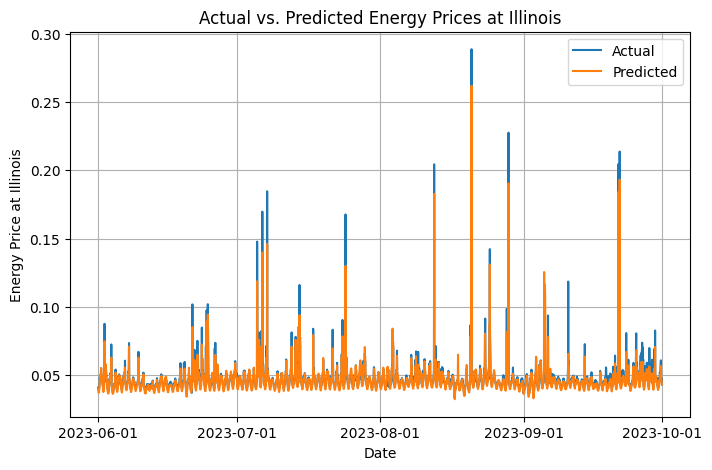

In [9]:
print(f"Best validation loss: {best_val_loss:4.2e}")
print(f"Best number of layers: {best_num_layers}")
print(f"Best hidden size: {best_hidden_size}")
predictions = best_model(X_test_tensor).detach().numpy()
plot_prediction(predictions)